In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if('db' not in category):
                continue
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                if('db' in category and price<fit_price):
                    continue
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    if('db' in category and price<upper_fit_price):
                        continue
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    count = 0
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 转债名称
            name = dat_cell['bond_nm']
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = name
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
  
            lst_data.append(lst_dat)
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio2'] #####ratio is float ratio, ratio is total ratio
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###this is a new try
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio2']#####ratio is float ratio, ratio is total ratio
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###this is a new try
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data = get_dat()
pd.DataFrame.from_dict(data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 385 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 397 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

In [37]:
put_df = put_arbitrage(data)

Finished processing 29 items


Strong Sell 113039 嘉泽转债 154.86 166.076
Sell 110070 凌钢转债 140.27 149.505
Sell 110072 广汇转债 100.72 150.091
Strong Sell 113595 花王转债 93.0 215.026
Strong Sell 128085 鸿达转债 161.6 165.932
Strong Sell 128127 文科转债 99.99 159.262

Add  132018 G三峡EB1 122.11 129.185
Add  128100 搜特转债 106.754 130.307
Add  128087 孚日转债 106.73 139.477
Add  128063 未来转债 121.499 141.174
Add  113610 灵康转债 117.12 141.325
Add  110033 国贸转债 132.83 142.005
Add  128108 蓝帆转债 121.659 142.355

Buy  110033 国贸转债 132.83 142.005
Buy  128108 蓝帆转债 121.659 142.355
Buy  113577 春秋转债 126.22 143.486
Buy  128037 岩土转债 113.258 143.760
Buy  123109 昌红转债 120.0 144.710
Buy  123098 一品转债 137.2 144.722
Buy  128143 锋龙转债 123.0 144.913
Buy  113541 荣晟转债 126.7 145.186
Buy  128133 奇正转债 119.787 145.563
Buy  123002 国祯转债 116.789 145.905
Buy  123080 海波转债 124.2 145.969
today coef [3.47432110e-03 1.18513913e-02 9.30901954e+01]
mse=41.234


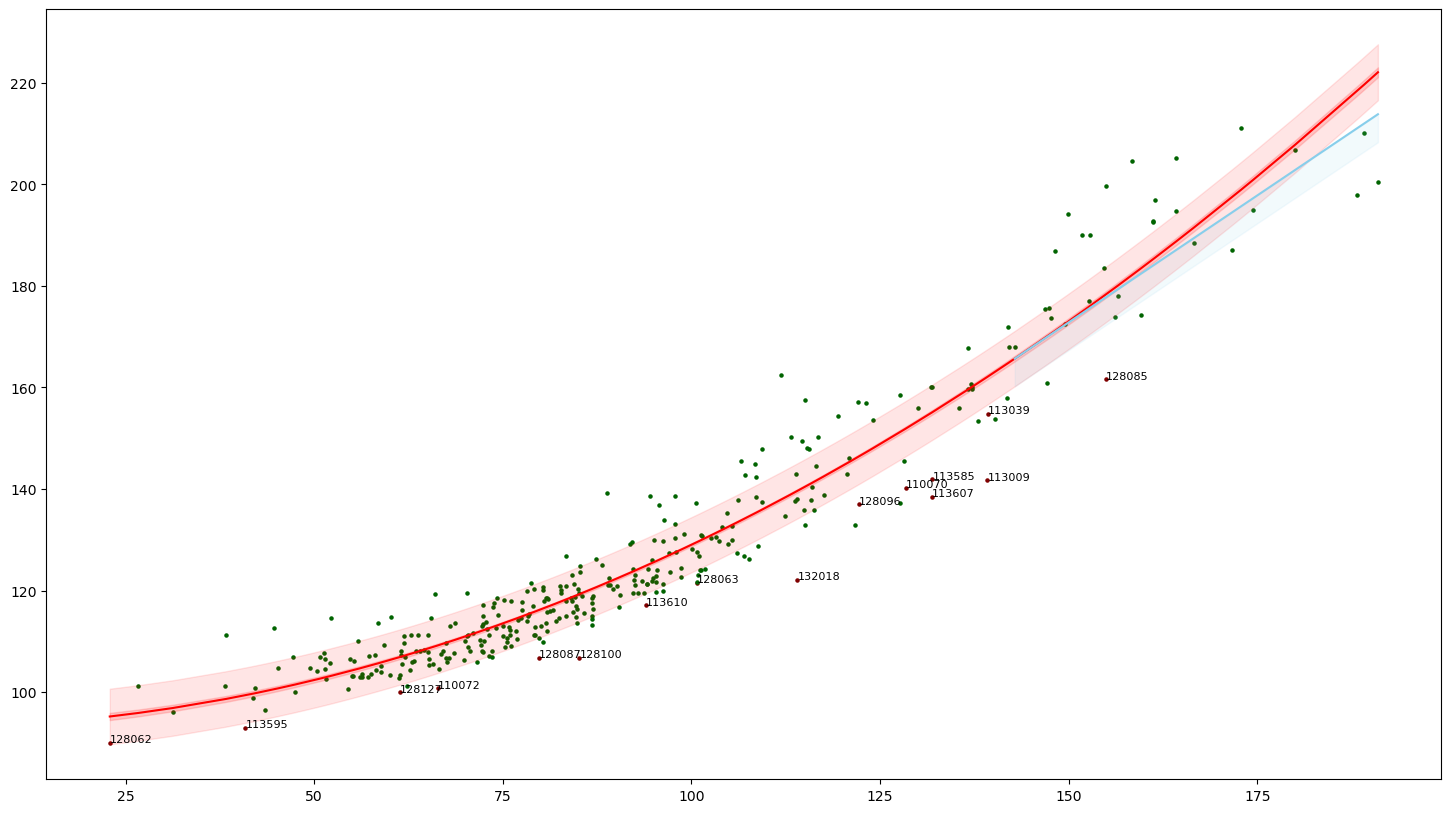

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
132014,18中化EB,188.240404,197.850,5.104959,202.954959,-3.751504,211.069558,205.561653,216.577464
128103,同德转债,190.995100,200.500,4.976515,205.476515,-3.750206,213.824254,208.312135,219.336373
123103,震安转债,189.151565,210.151,11.101909,221.252909,1.782119,211.980719,206.471432,217.490005
113537,文灿转债,180.061668,206.810,14.855095,221.665095,4.769761,202.890822,197.394743,208.386902


In [40]:
lp_df.loc['128063']

name                     未来转债
value               100.71156
price                 121.499
premium             20.640569
db_low             141.173798
lower_deviation     -2.086075
fit_price          129.523176
low_fit_price      124.087559
upper_fit_price    134.958792
Name: 128063, dtype: object

In [41]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

Sell 128062 亚药转债 89.99 375.284 293.158 0.314

Add  113009 广汽转债 141.72 143.512 1.792 -9.520
Add  132018 G三峡EB1 122.11 129.185 7.075 -9.001
Add  113607 伟20转债 138.45 143.476 5.026 -7.441
Add  128085 鸿达转债 161.6 165.932 4.332 -6.488
Add  128100 搜特转债 106.754 130.307 25.378 -6.235
Add  123098 一品转债 137.2 144.722 7.522 -5.852

Strong Buy 113009 广汽转债 141.72 143.512 1.792 -9.520
Strong Buy 132018 G三峡EB1 122.11 129.185 7.075 -9.001
Strong Buy 113607 伟20转债 138.45 143.476 5.026 -7.441
Strong Buy 128100 搜特转债 106.754 130.307 25.378 -6.235
Strong Buy 123098 一品转债 137.2 144.722 7.522 -5.852
Strong Buy 110033 国贸转债 132.83 142.005 9.175 -5.473
Buy 132014 18中化EB 197.85 202.955 5.105 -3.752
Buy 128103 同德转债 200.5 205.477 4.977 -3.750
Strong Buy 128087 孚日转债 106.73 139.477 33.816 -3.587
Buy 123068 弘信转债 153.69 163.262 9.572 -2.513
Strong Buy 113577 春秋转债 126.22 143.486 17.266 -2.292
Buy 113027 华钰转债 160.9 170.226 9.326 -2.266


In [42]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113009,广汽转债,139.224465,141.720,1.792454,143.512454,-9.520385,162.084534,156.631966,167.537103
132018,G三峡EB1,114.041755,122.110,7.074816,129.184816,-9.001002,139.627108,134.188291,145.065926
113607,伟20转债,131.824249,138.450,5.026200,143.476200,-7.441136,155.027972,149.580487,160.475457
128085,鸿达转债,154.889887,161.600,4.332183,165.932183,-6.487807,178.277867,172.811690,183.744044
128100,搜特转债,85.146009,106.754,25.377574,130.306855,-6.234505,119.287576,113.852115,124.723036
123098,一品转债,127.602147,137.200,7.521702,144.721702,-5.851644,151.172424,145.727451,156.617397
110033,国贸转债,121.667077,132.830,9.174974,142.004974,-5.472632,145.962070,140.520150,151.403989
113585,寿仙转债,131.921227,141.920,7.579351,149.499351,-5.178337,155.117986,149.670440,160.565532
110070,凌钢转债,128.411249,140.270,9.234978,149.504978,-4.223961,151.901688,146.456255,157.347120


In [43]:
my_df

,name,price,db_low
id,,,
132018,G三峡EB1,122.110,129.184816
128100,搜特转债,106.754,130.306855
128087,孚日转债,106.730,139.477229
128063,未来转债,121.499,141.173798
113610,灵康转债,117.120,141.324703
113607,伟20转债,138.450,143.476200
113009,广汽转债,141.720,143.512454
128096,奥瑞转债,136.999,149.137442
113585,寿仙转债,141.920,149.499351


today quartile 156.81538506299214


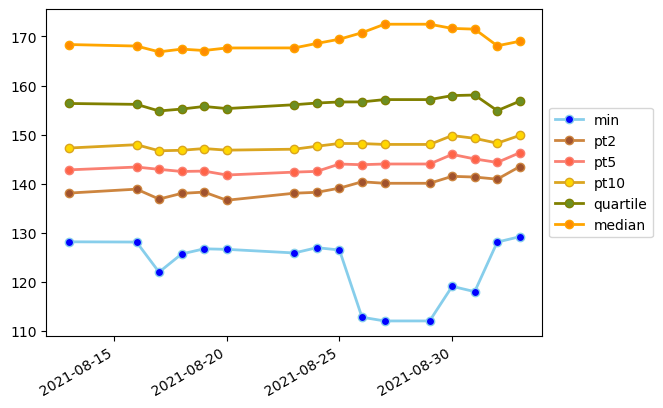

In [44]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 25.77646966733267


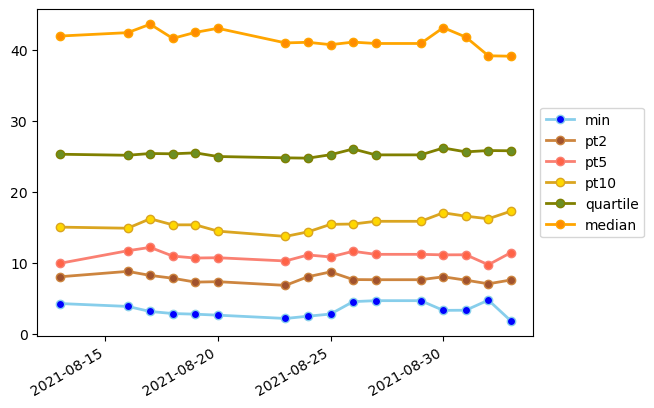

In [45]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 111.222


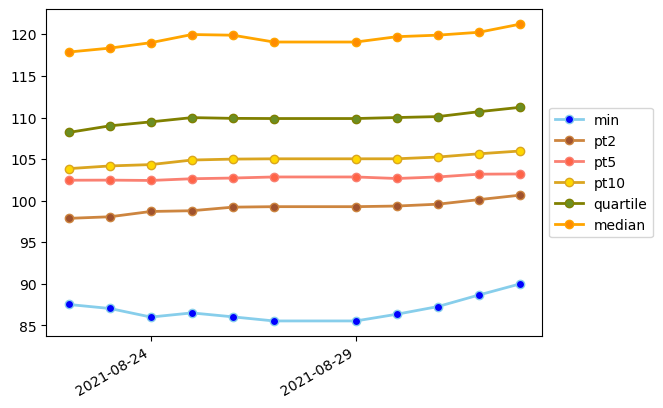

In [46]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [47]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_price,last_time,force_redeem,redeem_dt,force_redeem_price,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
132018,G三峡EB1,600900.ss,长江电力,122.110,119.35,2.48%,AAA,2.75,3.9%,3.9%,...,108.000,2.603,X,None,20.09,0.000000,0.0,114.041755,0.070748,129.184816
128100,搜特转债,002503.sz,搜于特,106.754,98.77,8.09%,A,2.03,19.6%,16.2%,...,112.000,4.523,X,None,2.11,0.018247,0.0,85.146009,0.253776,130.306855
128087,孚日转债,002083.sz,孚日股份,106.730,92.44,15.45%,AA-,1.02,17.3%,17.2%,...,108.000,4.293,X,None,5.85,0.010690,0.0,79.758633,0.338162,139.477229
128063,未来转债,002631.sz,德尔未来,121.499,111.74,8.73%,AA-,3.57,10.0%,9.8%,...,120.000,3.586,X,None,11.18,0.009658,0.0,100.711560,0.206406,141.173798
113610,灵康转债,603669.ss,灵康药业,117.120,100.93,16.04%,AA-,4.41,7.4%,7.4%,...,115.000,5.247,X,None,11.19,0.005030,0.0,93.915612,0.247077,141.324703
110033,国贸转债,600755.ss,厦门国贸,132.830,132.29,0.41%,AAA,0.63,7.0%,6.6%,...,108.000,0.342,X,None,8.74,0.000000,0.0,121.667077,0.091750,142.004974
128108,蓝帆转债,002382.sz,蓝帆医疗,121.659,109.16,11.45%,AA,1.55,7.6%,7.6%,...,108.000,4.734,N,None,23.71,0.000000,0.0,100.797664,0.206962,142.355249
113607,伟20转债,603568.ss,伟明环保,138.450,137.63,0.59%,AA,6.50,3.2%,3.2%,...,110.000,5.167,X,None,28.22,0.000000,0.0,131.824249,0.050262,143.476200
113577,春秋转债,603890.ss,春秋电子,126.220,111.60,13.10%,AA-,2.75,3.8%,3.3%,...,112.000,4.614,N,None,14.12,0.000000,0.0,107.635982,0.172656,143.485618


In [48]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_price,last_time,force_redeem,redeem_dt,force_redeem_price,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
128037,岩土转债,002542.sz,中化岩土,113.258,96.13,17.82%,AA,1.31,13.9%,11.2%,...,108.000,2.534,X,None,4.03,0.000000,0.0,86.786120,0.305024,143.760435
123109,昌红转债,300151.sz,昌红科技,120.000,99.36,20.77%,AA-,12.91,5.2%,3.3%,...,115.000,5.578,X,None,36.48,0.000227,0.0,96.205536,0.247329,144.710251
123098,一品转债,300723.sz,一品红,137.200,135.01,1.62%,AA-,6.34,10.0%,4.3%,...,118.000,5.405,N,None,33.12,0.000000,0.0,127.602147,0.075217,144.721702
128143,锋龙转债,002931.sz,锋龙股份,123.000,110.60,11.21%,A+,4.07,9.7%,8.7%,...,115.000,5.351,X,None,16.55,0.000000,0.0,100.891973,0.219126,144.912573
113541,荣晟转债,603165.ss,荣晟环保,126.700,113.10,12.03%,AA-,1.87,5.1%,5.1%,...,110.000,3.888,X,None,14.09,0.000000,0.0,106.932052,0.184865,145.186457
128133,奇正转债,002287.sz,奇正藏药,119.787,100.10,19.67%,AA,4.61,5.1%,5.1%,...,112.000,5.055,X,None,38.71,0.000000,0.0,95.238005,0.257765,145.563470
123002,国祯转债,300388.sz,节能国祯,116.789,94.38,23.75%,AA,1.52,4.6%,4.6%,...,106.000,2.227,X,None,10.87,0.000000,0.0,90.453001,0.291157,145.904672
123080,海波转债,300517.sz,海波重科,124.200,112.95,9.96%,A+,2.78,16.5%,9.7%,...,120.000,5.249,X,None,15.05,0.002381,0.0,101.796971,0.220076,145.969490
128071,合兴转债,002228.sz,合兴包装,109.885,84.93,29.39%,AA,1.25,6.8%,6.8%,...,110.000,3.953,X,None,5.43,0.006879,0.0,80.292893,0.368552,146.052275


In [49]:
lp_df[0:20]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113009,广汽转债,139.224465,141.720,1.792454,143.512454,-9.520385,162.084534,156.631966,167.537103
132018,G三峡EB1,114.041755,122.110,7.074816,129.184816,-9.001002,139.627108,134.188291,145.065926
113607,伟20转债,131.824249,138.450,5.026200,143.476200,-7.441136,155.027972,149.580487,160.475457
128085,鸿达转债,154.889887,161.600,4.332183,165.932183,-6.487807,178.277867,172.811690,183.744044
128100,搜特转债,85.146009,106.754,25.377574,130.306855,-6.234505,119.287576,113.852115,124.723036
123098,一品转债,127.602147,137.200,7.521702,144.721702,-5.851644,151.172424,145.727451,156.617397
110033,国贸转债,121.667077,132.830,9.174974,142.004974,-5.472632,145.962070,140.520150,151.403989
113585,寿仙转债,131.921227,141.920,7.579351,149.499351,-5.178337,155.117986,149.670440,160.565532
110070,凌钢转债,128.411249,140.270,9.234978,149.504978,-4.223961,151.901688,146.456255,157.347120


In [50]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

169.0217589343915
121.22
39.10257856738164


In [51]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128062,亚药转债,22.889003,89.99,293.158239,375.283879,0.313937,95.181681,89.708373,100.654990
132011,17浙报EB,26.679040,101.25,279.511413,378.953067,11.989771,95.879301,90.410043,101.348558


In [52]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_dt,force_redeem_price,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,89.990,25.42,254.08%,BB,3.59,50.3%,43.5%,...,11.38,2025-04-02,115.000,3.584,X,None,21.12,102.00,0.077053,1.687671
113595,花王转债,603007.ss,ST花王,93.000,46.68,99.24%,BBB+,0.96,30.6%,30.4%,...,4.84,2026-07-20,116.000,4.882,X,None,9.00,102.64,0.033516,2.991781
113576,起步转债,603557.ss,ST起步,96.520,45.69,111.26%,A,1.48,11.2%,11.1%,...,7.38,2026-04-09,115.000,4.603,N,None,13.71,103.04,0.024443,2.706849
113596,城地转债,603887.ss,城地香江,96.090,34.67,177.19%,AA-,0.92,40.3%,31.7%,...,16.98,2026-07-27,108.000,4.901,X,None,31.54,102.48,0.021613,3.010959
113589,天创转债,603608.ss,天创时尚,98.740,46.62,111.78%,AA,1.46,24.4%,24.4%,...,8.60,2026-06-23,110.000,4.808,X,None,15.98,102.48,0.012835,2.915068
113017,吉视转债,601929.ss,吉视传媒,100.540,63.73,57.76%,AA+,0.84,26.7%,26.7%,...,2.06,2023-12-27,106.000,2.318,X,None,3.83,101.04,0.011827,0.421918
128044,岭南转债,002717.sz,岭南股份,100.051,50.93,96.45%,AA-,1.03,19.5%,14.3%,...,4.14,2024-08-14,107.000,2.951,X,None,7.68,101.20,0.010913,1.052055
128127,文科转债,002775.sz,文科园林,99.990,84.63,18.15%,AA-,0.93,51.6%,44.8%,...,3.42,2026-08-19,115.000,4.964,X,None,6.34,102.64,0.008561,3.068493
113569,科达转债,603660.ss,苏州科达,100.830,45.14,123.40%,AA-,1.83,15.6%,15.6%,...,10.36,2026-03-09,115.000,4.518,X,None,19.24,102.64,0.006816,2.619178


In [53]:
time_decay_factor = 0.25

In [54]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y ** time_decay_factor + d 

In [55]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    ids = []
    names = []
    db_lows = []
    values = []
    prices = []
    times = []
    expires = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        price = db_df['price'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        premium = db_df['new_premium'][cb_id]
        db_low = db_df['db_low'][cb_id]
        force_redeem = db_df['force_redeem'][cb_id]
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        if(force_redeem != "Y"):
            maturity_dt  = db_df['maturity_dt'][cb_id]
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
        else:
            #continue
            redeem_dt    = db_df['redeem_dt'][cb_id]
            expire_dt = redeem_dt
            if(redeem_dt == None):
                time_to_exp = 30/365 ####1 month to be forced redeem
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_exp = days_interval.days/365
        
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)
        values.append(value)
        prices.append(price)
        times.append(time_to_exp)
        expires.append(expire_dt)

    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    values  = np.array(values)
    times   = np.array(times)
    prices  = np.array(prices)
    expires = np.array(expires)
    x = values
    y = times
    z = prices
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    z = z[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]
    expires = expires[indexes]
    values  = x
    times   = y
    prices  = z
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    #convert_value_limit = (1-coef[1])/2/coef[0]
    #price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    #ext_index = np.argmax(x>=convert_value_limit)
    #xext = x[ext_index:]
    #yext = xext+price_limit-convert_value_limit
    #piext = pi[ext_index:]

    td_data = []
    se = 0
    for i,cb_id in enumerate(ids):
        cb_name = names[i]
        db_low  = db_lows[i]
        value      = values[i]
        time_to_exp = times[i]
        expire_dt  = expires[i]
        price = prices[i]
        premium = price/value-1
        fit_price = zfit[i]
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_to_exp ** time_decay_factor + popt[3]
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'expire_dt':expire_dt}
        td_data.append(item)
        #plt.rcParams["figure.figsize"] = (18,10)
        #if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
        #    plt.scatter(x[i], y[i], marker='o', s=5,color='maroon')
        #    plt.text(x[i]+.03, y[i]+.03, cb_id, fontsize=8)
        #else:
        #    plt.scatter(x[i], y[i], marker='o', s=5,color='darkgreen')
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    #plt.plot(x,yfit,color='red')
    #plt.plot(xext,yext,color='skyblue')
    #plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    #plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    #plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    #plt.show()
    #plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return popt,td_df
    #return x,y

In [56]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            item = td_df.loc[cb_id]
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [57]:
# 0.01 43.179
# 0.1 43.288 43.682
# 0.2 43.351
# 0.25 43.468 43.871
# 0.3 43.488
# 0.4 43.624
# 0.5 43.791  44.217

In [58]:
#x,y = three_factor_arbitrage(db_df)
popt,td_df = three_factor_arbitrage(db_df)

[3.46981033e-03 3.41612879e-03 1.31002318e+01 7.52042101e+01]
143.60783087720617
mse=39.543
adjuse mse=38.155


In [59]:
 buy_sell_three(td_df,'mycb_list.csv',show_price=True)

Sell 113039 嘉泽转债 4.975342465753425 154.860 0.112 -4.713

Add  132018 G三峡EB1 2.6027397260273974 122.110 0.071 -11.102
Add  113607 伟20转债 5.167123287671233 138.450 0.050 -11.081
Add  128100 搜特转债 4.523287671232877 106.754 0.254 -10.857
Add  123098 一品转债 5.405479452054794 137.200 0.075 -9.803
Add  128085 鸿达转债 4.2904109589041095 161.600 0.043 -8.901
Add  113585 寿仙转债 4.767123287671233 141.920 0.076 -8.673

Have 132018 G三峡EB1 2.6027397260273974 122.110 0.071 -11.102
Have 113607 伟20转债 5.167123287671233 138.450 0.050 -11.081
Have 128100 搜特转债 4.523287671232877 106.754 0.254 -10.857
Buy 123098 一品转债 5.405479452054794 137.200 0.075 -9.803
Have 128085 鸿达转债 4.2904109589041095 161.600 0.043 -8.901
Have 113585 寿仙转债 4.767123287671233 141.920 0.076 -8.673
Have 110072 广汇转债 4.958904109589041 100.720 0.518 -8.649
Have 128087 孚日转债 4.293150684931507 106.730 0.338 -8.313
Have 110070 凌钢转债 4.610958904109589 140.270 0.092 -7.750
Have 113595 花王转债 4.882191780821918 93.000 1.275 -7.569
Have 113009 广汽转债 0.3890410958904

In [60]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,expire_dt
id,,,,,,,,,
132018,G三峡EB1,114.041755,2.602740,122.110,0.070748,129.184816,-11.102115,137.359848,2024-04-09
113607,伟20转债,131.824249,5.167123,138.450,0.050262,143.476200,-11.080553,155.702723,2026-11-01
128100,搜特转债,85.146009,4.523288,106.754,0.253776,130.306855,-10.856675,119.755461,2026-03-11
123098,一品转债,127.602147,5.405479,137.200,0.075217,144.721702,-9.803107,152.111670,2027-01-27
128085,鸿达转债,154.889887,4.290411,161.600,0.043322,165.932183,-8.901025,177.389482,2025-12-16
113585,寿仙转债,131.921227,4.767123,141.920,0.075794,149.499351,-8.673174,155.397933,2026-06-08
110072,广汇转债,66.351708,4.958904,100.720,0.517971,150.091309,-8.648900,110.255925,2026-08-17
128087,孚日转债,79.758633,4.293151,106.730,0.338162,139.477229,-8.312824,116.406682,2025-12-17
110070,凌钢转债,128.411249,4.610959,140.270,0.092350,149.504978,-7.750394,152.054849,2026-04-12


In [61]:
func((184,5.4), *popt)

213.27664679091657

In [62]:
td_df.loc['118002']

name                 天合转债
value          116.813921
time_to_exp      5.945205
price              150.19
premium           0.28572
db_low         178.762005
deviation        4.730238
fit_price       143.40653
expire_dt      2027-08-12
Name: 118002, dtype: object

In [63]:
db_df.loc['123098']

name                        一品转债
stock_id               300723.sz
stock_name                   一品红
price                      137.2
convert_value             135.01
premium_rt                 1.62%
rating_cd                    AA-
pb                          6.34
convert_amt_ratio          10.0%
convert_amt_ratio2          4.3%
next_put_dt           2025-01-27
put_price                100.000
put_convert_price          17.84
maturity_dt           2027-01-27
redeem_price             118.000
last_time                  5.405
force_redeem                   N
redeem_dt                   None
force_redeem_price         33.12
redeem_CAGR                  0.0
put_CAGR                     0.0
new_convert_value     127.602147
new_premium             0.075217
db_low                144.721702
Name: 123098, dtype: object

In [64]:
convert_value = 94.26
convert_amt_ratio = 0.069
func((convert_value/(1+convert_amt_ratio*convert_value/100),6),*popt)

123.18825732301127

In [65]:
121.98/(1+0.07*1.2198)

112.38398136699756

In [66]:
1+0.07*1.2198

1.085386

In [67]:
0.091*1.2954

0.11788140000000001

In [68]:
135.3/141.64-1

-0.044761366845523676

In [69]:
130/140-1

-0.0714285714285714